# Lab 7:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading the package
We begin by loading packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. We will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [2]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [3]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
r = requests.get(url, allow_redirects=True)
open(fn, 'wb').write(r.content)

1418242

Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [4]:
# TODO
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

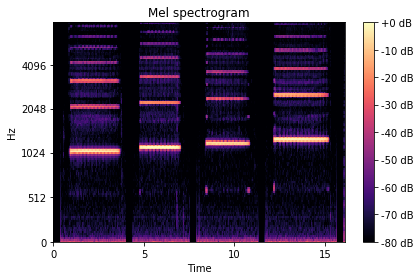

In [5]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [6]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class.


In [7]:
# TODO
print('number of sample = {}, each has {} features'.format(*Xtr.shape))
print('there are {} classes'.format(*np.unique(ytr).shape))

number of sample = 66247, each has 120 features
there are 10 classes


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [8]:
# TODO Scale the training and test matrices
Xtr_scale = (Xtr-np.mean(Xtr, axis=0))/np.std(Xtr, axis=0)
Xts_scale = (Xts-np.mean(Xtr, axis=0))/np.std(Xtr, axis=0)

## Importing Pytorch
* importing package
* determine use gpu or not
* determine use float or double

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils
import torch.nn.functional as F

USE_GPU = True

dtype = torch.float32 # float or double

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Defining a data set object

* Define dataset class that inherits pytorch dataset
* Define dataloader that could do shuffling, and loading data with multi-thread

In [10]:
class InstrumentDataset(Dataset):
    def __init__(self, X, Y):
        # init with np array X and Y
        self.X = X
        self.Y = Y
        pass
        
    def __len__(self):
        return (self.X).shape[0]

    def __getitem__(self, indice):
        # slice the array
        X = (self.X)[indice]
        Y = (self.Y)[indice]
        # turn to np tensor in cpu
        X = torch.from_numpy (X)
        Y = torch.from_numpy (np.array(Y))
        
        sample = {'data':X, 'label':Y}
        return sample

# Create dataset object for training and testing
TrDataSet = InstrumentDataset(Xtr_scale, ytr)
TsDataSet = InstrumentDataset(Xts_scale, yts)

In [11]:
# Define batch size
batch_size = 100

# Create data loader
Trloader = DataLoader(TrDataSet, batch_size=batch_size, shuffle=True)
Tsloader = DataLoader(TrDataSet, batch_size=batch_size, shuffle=True)

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), clear the keras session.  Then, create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation for the hidden layer, `softmax` for the output layer
* select the input and output shapes correctly
* print the model summary

In [12]:
# Create a 2 layer fully connected network

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        out = self.fc2(F.sigmoid(self.fc1(x)))
        return out

Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [78]:
# Create model and optimizer object

model = TwoLayerFC(120, 256, 10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [79]:
# Aux function for checking accuracy when training
def accuracy(input, target):
    
    target = target.detach().numpy()
    input = input.detach().numpy()
    input = np.argmax(input, axis=1)
    accMatrix = (input == target).astype(np.float32)
    
    return np.sum(accMatrix)/accMatrix.shape[0]

# Main training loop
def train(model, optimizer, device, dtype, epochs=1):

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    trainloss = np.zeros(epochs)
    valloss = np.zeros(epochs)
    
    trainacc = np.zeros(epochs)
    valacc = np.zeros(epochs)
    
    for e in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        for t, batch in enumerate(Trloader):
            model.train()  # put model to training mode
            x = batch['data']
            y = batch['label']
            
            x = x.to(device=device, dtype=dtype)  # move to cpu/gpu
            y = y.to(device=device, dtype=torch.long)

            out = model(x)
            accuracy(out, y)
            loss = F.cross_entropy(out, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            # No grads
            epoch_loss += loss.item()
            epoch_acc += accuracy(out, y)
            
        print('Epoch {0} finished ! Training Loss: {1:.4f}, Training Accuracy: {2:.4f}'.format(e, epoch_loss/(t), epoch_acc/(t)))
        trainloss[e] = epoch_loss/(t+1)
        trainacc[e] = epoch_acc/(t+1)
        
        valloss[e], valacc[e] = check (model, device, dtype)
    return trainloss, trainacc, valloss, valacc

# Validation loop
def check(model, device, dtype):

    model.eval()  # put model to evaluation mode
    with torch.no_grad():
        loss = 0
        acc = 0
        N = len(Tsloader)
        for t, batch in enumerate(Tsloader):
            x = batch['data']
            y = batch['label']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            out = model(x)

            loss +=  F.cross_entropy(out, y)
            acc += accuracy(out, y)

        print('validation loss = {0:.4f}, Accuracy = {1:.4f}'.format(loss/N, acc/N))
        return loss/N, acc/N

Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, use the return from model.fit to record the history of loss, accuracy, and validation accuracy in successive epochs. Use a batch size of 100.  Your final accuracy should be >99%. If you want, you could also use the callback class you defined to record the history.

In [80]:
# Training the model for 10 epochs
trloss, tracc, valloss, valacc = train(model, optimizer, device, dtype, epochs=10)

Epoch 0 finished ! Training Loss: 0.3557, Training Accuracy: 0.9048
validation loss = 0.1359, Accuracy = 0.9692
Epoch 1 finished ! Training Loss: 0.0973, Training Accuracy: 0.9784
validation loss = 0.0680, Accuracy = 0.9847
Epoch 2 finished ! Training Loss: 0.0572, Training Accuracy: 0.9878
validation loss = 0.0473, Accuracy = 0.9894
Epoch 3 finished ! Training Loss: 0.0401, Training Accuracy: 0.9918
validation loss = 0.0344, Accuracy = 0.9908
Epoch 4 finished ! Training Loss: 0.0301, Training Accuracy: 0.9938
validation loss = 0.0247, Accuracy = 0.9942
Epoch 5 finished ! Training Loss: 0.0237, Training Accuracy: 0.9953
validation loss = 0.0202, Accuracy = 0.9951
Epoch 6 finished ! Training Loss: 0.0195, Training Accuracy: 0.9963
validation loss = 0.0181, Accuracy = 0.9947
Epoch 7 finished ! Training Loss: 0.0162, Training Accuracy: 0.9975
validation loss = 0.0142, Accuracy = 0.9959
Epoch 8 finished ! Training Loss: 0.0138, Training Accuracy: 0.9979
validation loss = 0.0120, Accuracy =

Plot the training loss, accuracy and validation accuracy vs. epoch, using the returned history record from model.fit. You should produce two subplots. One subplot contains the curve of loss vs. epochs. The other subplot contains two curves, one for the training accuracy and another for the validation accuracy. You should see that the loss continuously decreases, the accuracy continuously increases, but the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

You coluld also try to plot the loss values saved in the `history_cb` class.  In addition to plot the metrics for every epoch, you could plot the `batch_loss` per batch. But your may want to plot the x-axis in epochs.  Note that the epoch in step `i` is `epoch = i*batch_size/ntr` where `batch_size` is the batch_size and `ntr` is the total number of training samples.

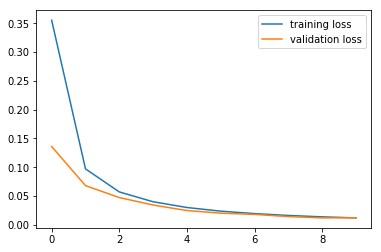

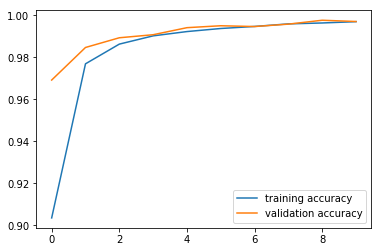

In [81]:
# TODO
plt.plot(np.arange(10), trloss, label='training loss')
plt.plot(np.arange(10), valloss, label='validation loss')
plt.legend()
plt.show()

plt.plot(np.arange(10), tracc, label='training accuracy')
plt.plot(np.arange(10), valacc, label = 'validation accuracy')
plt.legend()
plt.show()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying three learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model
* save the accuracy and losses

In [82]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
val_acc_hist = []

for lr in rates:
    print('using learning rate = {}'.format(lr))
    model = TwoLayerFC(120, 256, 10) # init a new model everytime !
    optimizer = optim.Adam(model.parameters(), lr=lr)
    trloss, tracc, valloss, valacc = train(model, optimizer, device, dtype, epochs=10)
    loss_hist.append(valloss)
    val_acc_hist.append(valacc)

using learning rate = 0.01
Epoch 0 finished ! Training Loss: 0.1058, Training Accuracy: 0.9687
validation loss = 0.0499, Accuracy = 0.9827
Epoch 1 finished ! Training Loss: 0.0262, Training Accuracy: 0.9931
validation loss = 0.0593, Accuracy = 0.9784
Epoch 2 finished ! Training Loss: 0.0205, Training Accuracy: 0.9949
validation loss = 0.0123, Accuracy = 0.9961
Epoch 3 finished ! Training Loss: 0.0163, Training Accuracy: 0.9960
validation loss = 0.0257, Accuracy = 0.9908
Epoch 4 finished ! Training Loss: 0.0138, Training Accuracy: 0.9970
validation loss = 0.0230, Accuracy = 0.9934
Epoch 5 finished ! Training Loss: 0.0142, Training Accuracy: 0.9967
validation loss = 0.0126, Accuracy = 0.9956
Epoch 6 finished ! Training Loss: 0.0167, Training Accuracy: 0.9965
validation loss = 0.0151, Accuracy = 0.9945
Epoch 7 finished ! Training Loss: 0.0117, Training Accuracy: 0.9979
validation loss = 0.0047, Accuracy = 0.9985
Epoch 8 finished ! Training Loss: 0.0101, Training Accuracy: 0.9984
validatio

Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower. Similarly, plot the accuracy and validation accuracy and make your observations. You may want to plot the three set of figures as three subplots.

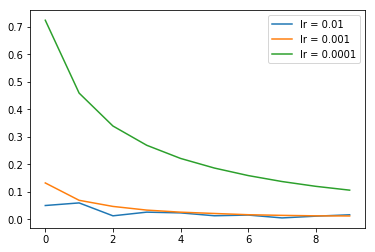

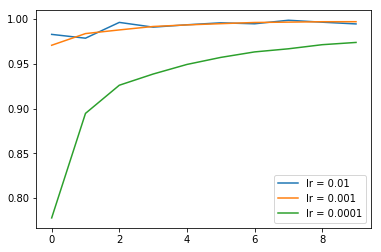

In [83]:
# TODO
for i in np.arange (len(rates)):
    plt.plot(np.arange(10), loss_hist[i], label='lr = ' + str(rates[i]))
plt.legend()
plt.show()

for i in np.arange (len(rates)):
    plt.plot(np.arange(10), val_acc_hist[i], label='lr = ' + str(rates[i]))
plt.legend()
plt.show()

Question: Which learning rate is the best ?

Answer: lr = 0.001